# Transport equation
### By: Pablo Sotomayor 

## Steady one-zone model

Let us first see how to numerically solve the transport equation:

${\large \frac{{\rm d}}{{\rm d}E}}[b(E)N(E)] + {\large \frac{N(E)}{T_{\rm esc}}} = Q(E)$

where:

$N(E)$ : Number of particles with energy in the range $(E, E+{\rm d}E)$ $[{\rm erg^{-1}}]$

$b(E) = {\rm d}E/{\rm d}t$: Timescale of continuous losses of particles $[{\rm erg\, s^{-1}}]$

$Q(E)$ : Particle injection function $[{\rm erg^{-1}\,s^{-1}}]$

$T_{\rm esc}$: Timescale of particle escape $[s^{-1}]$

Continuous losses can be radiative (synchrotron radiation, inverse Compton scattering, etc.) or adiabatic.

In [1]:
import numpy as np
from math import isclose
from scipy.integrate import simps
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Physical parameters
# Units: cgs

c = 29979245800.
sigmaTh = 6.6524e-25
alpha = 7.297352568e-3
me = 9.1094e-28
qe = 4.8032e-10
hp = 6.6261e-27
kb = 1.3807e-16
deg2rad = np.pi/180
rad2deg = 1/deg2rad
ev2erg = 1.60218e-12
erg2ev = 1./ev2erg

Data

In [3]:
Emin = 2*me*c*c                 # minimum energy
Emax = 10*1e12 *ev2erg          # maximum energy
p = 2                           # spectral index
Tesc = 0.1                      # timescale for particle escape
Linj = 1e36                     # power in particle injection
B = 1e4                         # magnetic field

Array of electron energy.

In [4]:
Egrid = 100

arrE = np.logspace(np.log10(Emin), np.log10(Emax), Egrid)

We calculate the injection function for those energies. We use the equation:

$$ L_{\rm inj} = \int_{E_{\rm min}}^{E_{\rm max}} {\rm d}E E Q(E) $$

From $Q(E) = Q_0 E^{-p}$:

$$ Q_0 = \frac{\int_{E_{\rm min}}^{E_{\rm max}} {\rm d}E E^{-p+1}}{L_{\rm inj}} $$


In [5]:
integral = simps(arrE**(-p+1),arrE)

Q0 = Linj/integral

arrQ = Q0*arrE**(-p)

Array of cooling time. We consider only synchrotron losses.

In [6]:
# Function that returns the synchrotron cooling time

def synchrotronCoolingTime(
    magneticField:float, 
    lorentzFactor:float, 
    particle: str, 
    pitchAngle:np.array=np.arcsin(np.sqrt(2/3))):
    if particle == 'electron':
        mass = me
        classicalRaiuds = qe**2 /mass/c/c
    power = (2*c*(classicalRaiuds*np.sin(pitchAngle)*lorentzFactor*magneticField)**2)/3
    time = lorentzFactor*mass*c*c/power
    return time

In [7]:
arrTcool = synchrotronCoolingTime(magneticField=B, lorentzFactor=arrE/me/c/c, particle='electron')

We set the array of timescale for particle escape.

In [10]:
arrTesc = 0.1*np.ones(Egrid)

We compute the particle distribution using the integral analytic expression

In [11]:
# Auxiliary function that returns limits of intervals in which we divide the range of integration

def getSubArrays(arr, tol=1e-6):    
    #---------------------------------------------------------------------
    # Getting the sub arrays
    # array 1: [Emin : 10Emin]
    # array 2: [10Emin : 100Emin]
    # ...
    # array N = [10^(N-1) Emin : 10^N Emin]
    # if 10^N Emin < Emax then one more array is added 
    #   interval N+1 = [10^N Emin : Emax]        
    #---------------------------------------------------------------------        
    xmin = arr[0]
    xmax = arr[-1]
    nArrays = int(np.log10(xmax/xmin))
    key = abs(xmax - xmin*10**nArrays) < tol*xmax 
    if not key:
        nArrays += 1
    #---------------------------------------------------------------------            
    # Setting the arrays of minimum and maximum energy
    # K sub arrays (K = N or K = N+1)
    # arrEmin = [Emin, 10Emin, 100Emin, ..., 10^(K-1)Emin]
    # arrEmax = [Emax, 10Emax, 100Emax, ..., min(10^K Emin, Emax)]
    #---------------------------------------------------------------------
    arrMin = np.ones(nArrays) 
    arrMax = np.ones(nArrays)
    for i in range(nArrays):
        arrMin[i] = xmin*10**(i)
        arrMax[i] = xmin*10**(i+1)    
    if not key:            
        arrMax[-1] = xmax
    return arrMin, arrMax 

In [14]:
arr = np.logspace(np.log10(1e-6), np.log10(4e15),100)
getSubArrays(arr)

(array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
        1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09,
        1.e+10, 1.e+11, 1.e+12, 1.e+13, 1.e+14, 1.e+15]),
 array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
        1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10,
        1.e+11, 1.e+12, 1.e+13, 1.e+14, 1.e+15, 4.e+15]))

In [15]:
from math import exp

def transportEquation(
    particleEnergy:float,
    arrEnergy:np.array,
    arrInjection:np.array,
    arrCoolingTime:np.array,
    escapeTime=None,
    escapeEnergyDependent:bool=False,
    timeDependent:bool=False)->np.array:
       
    if timeDependent is False:
        #---------------------------------------------------------------------
        # Getting Emin and Emax for the integration
        #---------------------------------------------------------------------
        Emin = particleEnergy
        Emax = arrEnergy[-1]
        if Emax < Emin:
            errorString = 'The particle energy must be lower than the \
                maximum energy'
            raise ValueError(errorString)
        if isclose(Emin,Emax):
            return 0
        #---------------------------------------------------------------------
        # Getting the arrays of E and Q for the integration
        #---------------------------------------------------------------------
        arrQ = np.delete(arrInjection,np.where(arrEnergy < Emin))        
        arrE = np.delete(arrEnergy,np.where(arrEnergy < Emin))        
        #---------------------------------------------------------------------            
        # Setting the arrays of minimum and maximum energy 
        # K intervals 
        # arrEmin = [Emin, 10Emin, 100Emin, ..., 10^(K-1)Emin]
        # arrEmax = [Emax, 10Emax, 100Emax, ..., Emax]
        #---------------------------------------------------------------------
        arrEmin = getSubArrays(arrE)[0]
        arrEmax = getSubArrays(arrE)[1]
        nArrays = len(arrEmin) 
        partialIntegral = np.ones(nArrays)         
        #---------------------------------------------------------------------
        # Distributing the integral in nArrays partial integrals
        # integral = sum(partialIntegral)
        #---------------------------------------------------------------------
        for i in range(nArrays):
            #-----------------------------------------------------------------
            # Solving the i-th integral
            # arrE_ for E in [arrEmin[i]:arrEmax[i]]
            # arrQ_ for Q in [Q(arrEmin[i]):Q(arrEmax[i])]
            # IF_ for IF in [IF(arrEmin[i]):IF(arrEmax[i])]
            #-----------------------------------------------------------------
            arrE_ = np.linspace(arrEmin[i],arrEmax[i],10)
            arrQ_ = np.interp(arrE_,arrE,arrQ)           
            IF_ = np.zeros(10)                            
            for j in range(10):
                arrE__ = np.linspace(particleEnergy,arrE_[j],10)
                arrTcool__ = np.interp(arrE__,arrEnergy,arrCoolingTime)               
                IF_[j] = integratingFactor(arrE__,arrTcool__,escapeTime,
                                           escapeEnergyDependent)                
            partialIntegral[i] = simps(arrQ_*IF_,arrE_)
        particleTcool = np.interp(particleEnergy,arrEnergy,arrCoolingTime)
        particleDensity = particleTcool*sum(partialIntegral)/particleEnergy
    #=========================================================================
    # Non-stationary case
    #=========================================================================    
    else:
        raise NotImplementedError
    return particleDensity

def integratingFactor(
    arrEnergy:np.array,
    arrCoolingTime:np.array,
    escapeTime,
    keyEscape:bool):

    #------------------------------------------------------------------------
    # Getting Emin and Emax for the integration
    #------------------------------------------------------------------------
    Emin = arrEnergy[0]
    Emax = arrEnergy[-1]
    if Emax < Emin:
        raise ValueError('Minimum energy must be lower than the maximum energy')
    if isclose(Emin,Emax):        
        return 1
    #------------------------------------------------------------------------
    # Getting sub-intervals for the integration
    #------------------------------------------------------------------------
    arrEmin = getSubArrays([Emin,Emax])[0]
    arrEmax = getSubArrays([Emin,Emax])[1]
    nArrays = len(arrEmin)
    partialIntegral = np.zeros(nArrays)
    #------------------------------------------------------------------------
    # Distributing the integral in nArrays partial integrals
    # integral = sum(partialIntegral)
    #------------------------------------------------------------------------
    for i in range(nArrays):
        #--------------------------------------------------------------------
        # For the ith partial integral we define the array of energies arrE,
        # the array of cooling times arrTcool, and the array of the escape 
        # times arrTesc, if applicable.
        #--------------------------------------------------------------------
        arrE = np.linspace(arrEmin[i],arrEmax[i],10)        
        arrTcool = np.interp(arrE,arrEnergy,arrCoolingTime)        
        if keyEscape is False:
            #----------------------------------------------------------------
            # When the escape does not depend on the energy of the particles, 
            # the integral depends only on the cooling of the particles
            #----------------------------------------------------------------
            partialIntegral[i] = simps(arrTcool/arrE,arrE)
        else:           
            partialIntegral[i] = simps(arrTcool/arrE/escapeTime,arrE)
    integral = sum(partialIntegral)    
    if keyEscape is False and escapeTime is not None:
        integral /= escapeTime
    return np.exp(-integral)

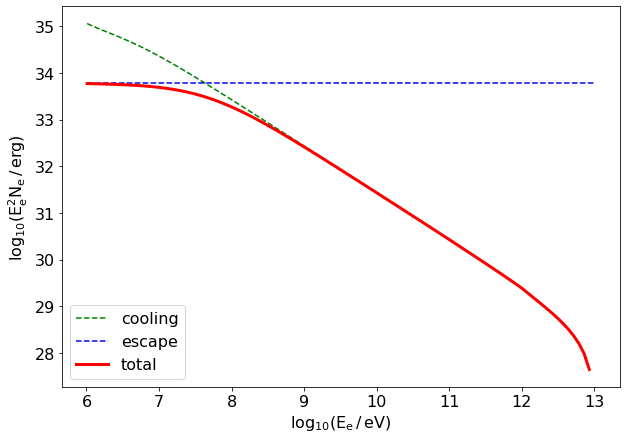

In [ ]:
arrDistribution_cool = np.zeros(Egrid)

for i in range(Egrid):        
    arrDistribution_cool[i] = transportEquation(particleEnergy=arrE[i],
                                               arrEnergy=arrE,
                                               arrInjection=arrQ,
                                               arrCoolingTime=arrTcool,
                                               escapeTime=None,
                                               escapeEnergyDependent=False)


arrDistribution_esc = arrQ*arrTesc

arrDistribution_total = 1./(1./arrDistribution_esc + 1./arrDistribution_cool)

plt.figure(figsize=(10,7))
plt.plot(np.log10(arrE*erg2ev),np.log10(arrE*arrE*arrDistribution_cool), ls = "--", c='green', label='cooling')
plt.plot(np.log10(arrE*erg2ev),np.log10(arrE*arrE*arrDistribution_esc), ls = "--", c='blue', label='escape')
plt.plot(np.log10(arrE*erg2ev),np.log10(arrE*arrE*arrDistribution_total), lw=3, c='red', label='total')
plt.xlabel(r"$\log_{10} ({\rm E_{e}\,/\,eV})$", fontsize=16)
plt.ylabel(r"$\log_{10} ({\rm E_{e}^2 N_{e}\,/\,erg})$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

A change in slope is observed in the particle spectrum. Breakdown occurs at the transition from the exhaust-dominated regime to the cooling-dominated regime.

We plot the cooling and escape timescales.

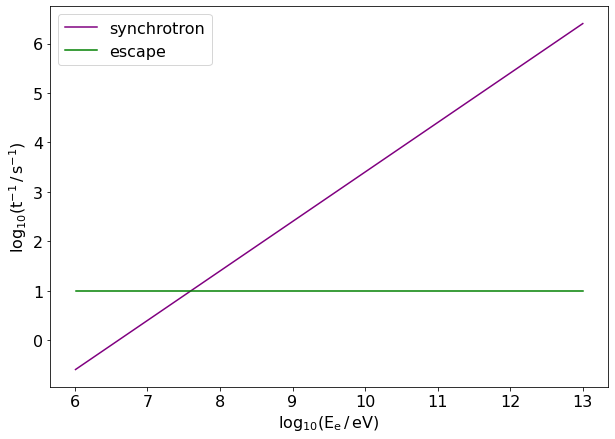

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(np.log10(arrE*erg2ev), -np.log10(arrTcool),c='purple', label='synchrotron')
plt.plot(np.log10(arrE*erg2ev), -np.log10(arrTesc),c='green', label='escape')
plt.xlabel(r"$\log_{10} ({\rm E_{e}\,/\,eV})$", fontsize=16)
plt.ylabel(r"$\log_{10} ({\rm t^{-1}\,/\,s^{-1}})$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

For electrons with $E_{\rm e} < 30\, {\rm MeV}$, escape from the acceleration region dominates. Synchrotron radiation cooling is dominant for $E_{\rm e} > 30\,{\rm MeV}$.

## Time-dependent one-zone model

${\large \frac{\partial N(E,t)}{\partial t} + \frac{\partial}{\partial E}}[b(E)N(E)] + {\large \frac{N(E)}{T_{\rm esc}}} = Q(E)$

where

$Q(E) = K E^{-p} \delta(t)$

In the case of radiative losses where $b(E) = AE^2$ , the solution is given by:

$N(E) = K E^{-p} (1 - AEt)^{p-2}$, para $AEt \leq 1$

$N(E) = 0$, para $AEt > 1$

In particular, for synchrotron losses:

$A = {\large \frac{4}{3}}\sigma_{\rm T}c {\large \frac{U_{\rm B}}{(mc^2)^2}}$

We consider that at $t=0$ the total energy in relativistic particles is:

$$E = \int_{E_{\rm min}}^{E_{\rm max}} {\rm d}E E N(E,t=0) = 10^{30}\,{\rm erg} $$

In [ ]:
# Data

Emin = 1e6 *ev2erg
Emax = 1e2 * 1e9 *ev2erg
B = 10
Et = 1e30
p = 2.3

In [ ]:
Egrid = 1000

arrE = np.logspace(np.log10(Emin), np.log10(Emax), Egrid)

In [ ]:
# Calculation of the normalization constant

uB = B**2 /8/np.pi
A = (4/3.)*sigmaTh*uB/me/me/c/c/c

integral = simps(A*arrE**(-p+1),arrE)

K = Et/integral

In [ ]:
# Function to calculate particle distribution

def distribution(particleEnergy, spectralIndex, magneticField, normalizationConstant, time):
    uB = magneticField**2 /8/np.pi
    A = (4/3.)*sigmaTh*uB/me/me/c/c/c
    x = A*particleEnergy*time
    if x <= 1:
        return normalizationConstant*particleEnergy**(-p) *(1 - x)**(p-2)
    else:
        return 0

In [ ]:
# Particle distribution for some times

arrDistribution_1e2 =  np.zeros(Egrid)
for i in range(Egrid):
    arrDistribution_1e2[i] = distribution(particleEnergy = arrE[i], 
                                        spectralIndex = p, 
                                        magneticField = B, 
                                        normalizationConstant = K, 
                                        time = 1e2)

arrDistribution_1e4 =  np.zeros(Egrid)
for i in range(Egrid):
    arrDistribution_1e4[i] = distribution(particleEnergy = arrE[i], 
                                        spectralIndex = p, 
                                        magneticField = B, 
                                        normalizationConstant = K, 
                                        time = 1e4)

arrDistribution_1e6 =  np.zeros(Egrid)
for i in range(Egrid):
    arrDistribution_1e6[i] = distribution(particleEnergy = arrE[i], 
                                        spectralIndex = p, 
                                        magneticField = B, 
                                        normalizationConstant = K, 
                                        time = 1e6)

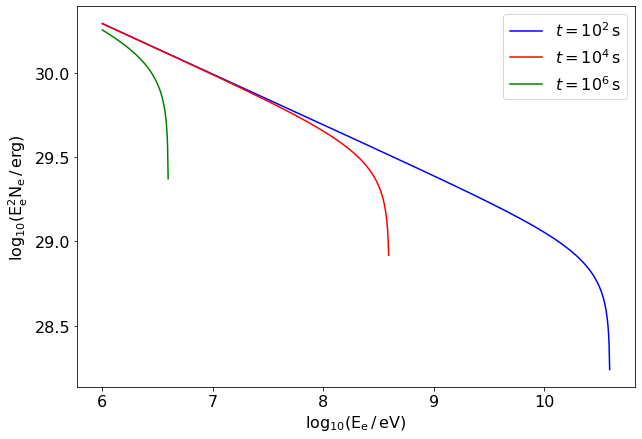

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(np.log10(arrE*erg2ev),np.log10(arrE*arrE*arrDistribution_1e2), ls = "-", c='blue', label=r'$t=10^2\,{\rm s}$')
plt.plot(np.log10(arrE*erg2ev),np.log10(arrE*arrE*arrDistribution_1e4), ls = "-", c='red', label=r'$t=10^4\,{\rm s}$')
plt.plot(np.log10(arrE*erg2ev),np.log10(arrE*arrE*arrDistribution_1e6), ls = "-", c='green', label=r'$t=10^6\,{\rm s}$')
plt.xlabel(r"$\log_{10} ({\rm E_{e}\,/\,eV})$", fontsize=16)
plt.ylabel(r"$\log_{10} ({\rm E_{e}^2 N_{e}\,/\,erg})$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

The maximum energy reached by the electrons is lower as time progresses since injection.

In [ ]:
arrTcool = synchrotronCoolingTime(magneticField=B, lorentzFactor=arrE/me/c/c, particle='electron')

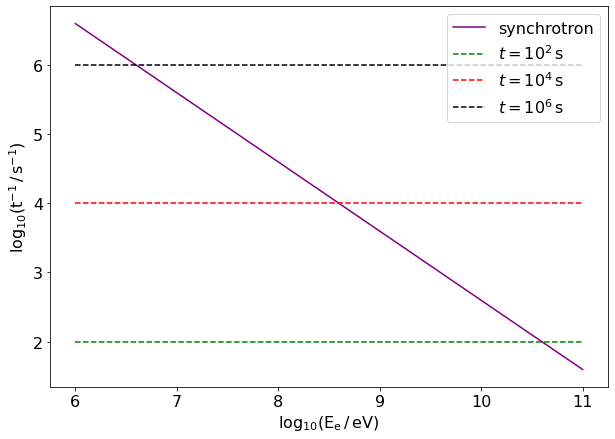

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(np.log10(arrE*erg2ev), np.log10(arrTcool),c='purple', label='synchrotron')
plt.plot(np.log10(arrE*erg2ev), np.log10(100*np.ones(Egrid)),c='green', ls ="--", label=r'$t=10^2\,{\rm s}$')
plt.plot(np.log10(arrE*erg2ev), np.log10(1e4*np.ones(Egrid)),c='red', ls="--", label=r'$t=10^4\,{\rm s}$')
plt.plot(np.log10(arrE*erg2ev), np.log10(1e6*np.ones(Egrid)),c='black', ls="--", label=r'$t=10^6\,{\rm s}$')
plt.xlabel(r"$\log_{10} ({\rm E_{e}\,/\,eV})$", fontsize=16)
plt.ylabel(r"$\log_{10} ({\rm t^{-1}\,/\,s^{-1}})$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

The maximum energy of the electrons is determined by the synchrotron cooling and the time since injection.